In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from statsmodels.formula.api import ols
!pip install bioinfokit
!pip install pingouin
import pingouin as pg
from bioinfokit.analys import stat
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
data = pd.read_csv('diabetes.csv')

In [3]:
data

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.describe()

# in BMI, the min is 0, which means there's missing values

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [6]:
# how many Insulin 0s?
data.Insulin.value_counts().head(5)

0      374
105     11
130      9
140      9
120      8
Name: Insulin, dtype: int64

# 1. DATA CLEANING

In [7]:
# Replacing 0s by NaN for columns where 0s aren't possible; so they don't count in the median for next step

data['BMI'] = data['BMI'].replace(0, np.nan)
data['Glucose'] = data['Glucose'].replace(0, np.nan)
data['SkinThickness'] = data['SkinThickness'].replace(0, np.nan)
data['BloodPressure'] = data['BloodPressure'].replace(0, np.nan)

In [8]:
data.BMI.median()

32.3

In [9]:
data.Glucose.median()
# normal plasma glucose levels are <140 mg/dL, so that seems plausible
# > 140 indicates pre-diabetic
# > 200 indicates diabetes

117.0

In [10]:
data.SkinThickness.median()
# 23mm is the normal thickness for women, so that looks ok

29.0

In [11]:
data.BloodPressure.median()
# that's in the normal range, so all good

72.0

In [12]:
# For columns where 0s aren't possible, replacing with the median value
# median instead of mean because there's probably other noisy outliers I don't have the domain knowledge to spot
# so median being less influenced by outliers, I'll use that

data['BMI'] = data['BMI'].replace(np.nan, data['BMI'].median())
data['Glucose'] = data['Glucose'].replace(np.nan, data['Glucose'].median())
data['SkinThickness'] = data['SkinThickness'].replace(np.nan, data['SkinThickness'].median())
data['BloodPressure'] = data['BloodPressure'].replace(np.nan, data['BloodPressure'].median())

# for Insulin, wasn't able to find information on whether 0 is possible or not for this specific test
# it seems more likely that 0s are ok than not, so I'm not touching that variable.
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073   79.799479   
std       3.369578   30.438286      12.096642       8.791221  115.244002   
min       0.000000   44.000000      24.000000       7.000000    0.000000   
25%       1.000000   99.750000      64.000000      25.000000    0.000000   
50%       3.000000  117.000000      72.000000      29.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.348958  
std      6.875177                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.300000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [13]:
data.loc[data['BMI']==18.2]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
418            1     83.0           68.0           29.0        0  18.2   
438            1     97.0           70.0           15.0        0  18.2   
526            1     97.0           64.0           19.0       82  18.2   

     DiabetesPedigreeFunction  Age  Outcome  
418                     0.624   27        0  
438                     0.147   21        0  
526                     0.299   21        0

In [14]:
# it's very weird that the minimum BMI is 18 (which is in the normal range) while the min for SkinThickness
# is 7, which indicates extreme underweight-ness
data.loc[data['SkinThickness']==7]
# one has a healthy BMI, the other is overweight, which doesn't really add up with the 7 skin thickness, 
# but I'm not a doctor so idk, i'll leave them alone

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
254           12     92.0           62.0            7.0      258  27.6   
519            6    129.0           90.0            7.0      326  19.6   

     DiabetesPedigreeFunction  Age  Outcome  
254                     0.926   44        1  
519                     0.582   60        0

In [15]:
data['Outcome'].value_counts()

# -> unbalanced

0    500
1    268
Name: Outcome, dtype: int64

In [16]:
data_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars=['Pregnancies', 'Glucose', 
                                                                       'BloodPressure', 'SkinThickness', 
                                                                       'Insulin', 'BMI', 
                                                                       'DiabetesPedigreeFunction', 'Age', 
                                                                       'Outcome'])

data_melt

index     variable  value
0         0  Pregnancies    6.0
1         1  Pregnancies    1.0
2         2  Pregnancies    8.0
3         3  Pregnancies    1.0
4         4  Pregnancies    0.0
...     ...          ...    ...
6907    763      Outcome    0.0
6908    764      Outcome    0.0
6909    765      Outcome    0.0
6910    766      Outcome    1.0
6911    767      Outcome    0.0

[6912 rows x 3 columns]

# 2. VISUALIZATION

In [17]:
fig1 = px.box(data, y='Pregnancies', width=300, title="Pregnancies")
fig1

In [18]:
px.histogram(data, x='Pregnancies')

In [19]:
fig2 = px.box(data,y='BMI',width=300, title="BMI")
fig2

In [20]:
px.histogram(data, x='BMI')

In [21]:
fig3 = px.box(data, y='Insulin',width=300,title="Insulin")
fig3

In [22]:
px.histogram(data, x='Insulin')
# very weird

In [23]:
fig4 = px.box(data, y='Glucose', width=300, title="Glucose")
fig4

# according to my quick search, >200 indicates diabetes
# >140 indicated pre-diabetic (at risk)
# but if I have 200+ diabetics in my dataset, why is no one above 200? i'm confused

In [24]:
px.histogram(data, x='Glucose')

In [25]:
fig5 = px.box(data, y='Age',width=300, title="Age")
fig5

In [26]:
px.histogram(data, x='Age')

In [27]:
fig6 = px.box(data, y='BloodPressure',width=300, title="BloodPressure")
fig6

In [28]:
px.histogram(data, x='BloodPressure')

In [29]:
fig7 = px.box(data, y='SkinThickness',width=300, title="SkinThickness")
fig7

In [30]:
px.histogram(data, x='SkinThickness')
# there's a very clear mode

In [31]:
fig8 = px.box(data, y='DiabetesPedigreeFunction',width=300,title="Hereditary Risk")
fig8

In [32]:
px.histogram(data, x='DiabetesPedigreeFunction')

In [33]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure()

for col in data:
  fig.add_trace(go.Box(y=data[col].values, name=data[col].name))
  
fig.show()

In [35]:
px.scatter(data, x="BMI", y="SkinThickness")

# 3. Categorizing numerical variables

### BMI

In [36]:
# BMI scale for women
# under 18.5: underweight
# 18.5—24.9: healthy
# 25.0—29.9: overweight
# over 30: obese

# https://cmdlinetips.com/2019/12/how-to-discretize-bin-a-variable-in-python/

In [37]:
data['BMI_binned'] = pd.cut(x=data['BMI'], bins=[0,18.5,25,30,50],
                           labels = ['underweight', 'healthy', 'overweight', 'obese'])

# took the categories from here https://www.medicalnewstoday.com/articles/323586#cutoff-points

In [38]:
data.BMI_binned.value_counts()

obese          468
overweight     180
healthy        108
underweight      4
Name: BMI_binned, dtype: int64

In [39]:
BMI_hist = px.histogram(data, x="BMI_binned", 
                        category_orders={"BMI_binned":['underweight','healthy','overweight',
                                                    'obese']}, 
                        color="Outcome",
                       labels={'BMI_binned':'BMI'})
BMI_hist

# since there are only 4 underweight, disregard it in the analysis, or group with healthy?

### Pregnancies

In [40]:
data['Pregnancies_binned2'] = pd.cut(x=data['Pregnancies'], bins=[-1,1,3,6,20],
                           labels = ['0-1','2-3','4-6','7+'])

data.Pregnancies_binned2.value_counts()

0-1    246
2-3    178
4-6    175
7+     169
Name: Pregnancies_binned2, dtype: int64

In [41]:
px.histogram(data, x="Pregnancies_binned2", color="Outcome", 
             category_orders={"Pregnancies_binned2":['0-1','2-3','4-6','7+']},
            labels={'Pregnancies_binned2':'Number of pregnancies'})

### Age

In [42]:
data['Age_binned'] = pd.cut(x=data['Age'], bins=[0,29,39,49,100],
                           labels = ['20s','30s','40s','50s+'])

data

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0        0  33.6   
1              1     85.0           66.0           29.0        0  26.6   
2              8    183.0           64.0           29.0        0  23.3   
3              1     89.0           66.0           23.0       94  28.1   
4              0    137.0           40.0           35.0      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10    101.0           76.0           48.0      180  32.9   
764            2    122.0           70.0           27.0        0  36.8   
765            5    121.0           72.0           23.0      112  26.2   
766            1    126.0           60.0           29.0        0  30.1   
767            1     93.0           70.0           31.0        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  BMI_binned Pregnancies_binned2  \
0                       0.627   50        1       obese                 4-6   
1                       0.351   31        0  overweight                 0-1   
2                       0.672   32        1     healthy                  7+   
3                       0.167   21        0  overweight                 0-1   
4                       2.288   33        1       obese                 0-1   
..                        ...  ...      ...         ...                 ...   
763                     0.171   63        0       obese                  7+   
764                     0.340   27        0       obese                 2-3   
765                     0.245   30        0  overweight                 4-6   
766                     0.349   47        1       obese                 0-1   
767                     0.315   23        0       obese                 0-1   

    Age_binned  
0         50s+  
1          30s  
2          30s  
3          20s  
4          30s  
..         ...  
763       50s+  
764        20s  
765        30s  
766        40s  
767        20s  

[768 rows x 12 columns]

In [43]:
data.Age_binned.value_counts()

20s     396
30s     165
40s     118
50s+     89
Name: Age_binned, dtype: int64

In [44]:
px.histogram(data, x="Age_binned", 
             category_orders={"Age_binned":['20s','30s','40s','50s+']},
             color="Outcome",labels={'Age_binned':'Age'})

### Glucose

In [45]:
# this website (https://myhealth.alberta.ca/Health/pages/conditions.aspx?hwid=hw44896)
# says that for this particular test, "Each lab has a different range for what's normal"
# since kaggle doesn't give any info, I can't base my binning on normal ranges
# so i'll bin using quartiles as the cutoffs

In [46]:
data['Glucose_binned'] = pd.cut(x=data['Glucose'], bins=[43,100,120,140,201],
                           labels = ['44-98','99-117','118-140','141-200'])

data

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0        0  33.6   
1              1     85.0           66.0           29.0        0  26.6   
2              8    183.0           64.0           29.0        0  23.3   
3              1     89.0           66.0           23.0       94  28.1   
4              0    137.0           40.0           35.0      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10    101.0           76.0           48.0      180  32.9   
764            2    122.0           70.0           27.0        0  36.8   
765            5    121.0           72.0           23.0      112  26.2   
766            1    126.0           60.0           29.0        0  30.1   
767            1     93.0           70.0           31.0        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  BMI_binned Pregnancies_binned2  \
0                       0.627   50        1       obese                 4-6   
1                       0.351   31        0  overweight                 0-1   
2                       0.672   32        1     healthy                  7+   
3                       0.167   21        0  overweight                 0-1   
4                       2.288   33        1       obese                 0-1   
..                        ...  ...      ...         ...                 ...   
763                     0.171   63        0       obese                  7+   
764                     0.340   27        0       obese                 2-3   
765                     0.245   30        0  overweight                 4-6   
766                     0.349   47        1       obese                 0-1   
767                     0.315   23        0       obese                 0-1   

    Age_binned Glucose_binned  
0         50s+        141-200  
1          30s          44-98  
2          30s        141-200  
3          20s          44-98  
4          30s        118-140  
..         ...            ...  
763       50s+         99-117  
764        20s        118-140  
765        30s        118-140  
766        40s        118-140  
767        20s          44-98  

[768 rows x 13 columns]

In [47]:
data.Glucose_binned.value_counts()

99-117     210
44-98      209
141-200    192
118-140    157
Name: Glucose_binned, dtype: int64

In [48]:
px.histogram(data, x="Glucose_binned", 
             category_orders={"Glucose_binned":['44-98','99-117','118-140','141-200']},
             color="Outcome", labels={'Glucose_binned':'Glucose'})

### Blood Pressure

In [49]:
# - a normal D.P. is between 60 and 80
# - high pressure is above 90, low pressure is under 60
# - between 80 and 90 means "may be at risk of developing high pressure"
# so I can do 4 bins: under 60 (low pressure), 60-80 (normal pressure), 80-90 (at risk of developing high pressure), 90+ (high pressure)

# binning according to these cutoffs

In [50]:
data['BloodPressure_binned'] = pd.cut(x=data['BloodPressure'], bins=[23,61,81,90,123],
                           labels = ['Low (<60)','Normal (60-80)','Above Normal (81-89)','High (90+)'])

data

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0        0  33.6   
1              1     85.0           66.0           29.0        0  26.6   
2              8    183.0           64.0           29.0        0  23.3   
3              1     89.0           66.0           23.0       94  28.1   
4              0    137.0           40.0           35.0      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10    101.0           76.0           48.0      180  32.9   
764            2    122.0           70.0           27.0        0  36.8   
765            5    121.0           72.0           23.0      112  26.2   
766            1    126.0           60.0           29.0        0  30.1   
767            1     93.0           70.0           31.0        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  BMI_binned Pregnancies_binned2  \
0                       0.627   50        1       obese                 4-6   
1                       0.351   31        0  overweight                 0-1   
2                       0.672   32        1     healthy                  7+   
3                       0.167   21        0  overweight                 0-1   
4                       2.288   33        1       obese                 0-1   
..                        ...  ...      ...         ...                 ...   
763                     0.171   63        0       obese                  7+   
764                     0.340   27        0       obese                 2-3   
765                     0.245   30        0  overweight                 4-6   
766                     0.349   47        1       obese                 0-1   
767                     0.315   23        0       obese                 0-1   

    Age_binned Glucose_binned BloodPressure_binned  
0         50s+        141-200       Normal (60-80)  
1          30s          44-98       Normal (60-80)  
2          30s        141-200       Normal (60-80)  
3          20s          44-98       Normal (60-80)  
4          30s        118-140            Low (<60)  
..         ...            ...                  ...  
763       50s+         99-117       Normal (60-80)  
764        20s        118-140       Normal (60-80)  
765        30s        118-140       Normal (60-80)  
766        40s        118-140            Low (<60)  
767        20s          44-98       Normal (60-80)  

[768 rows x 14 columns]

In [51]:
data.BloodPressure_binned.value_counts()

Normal (60-80)          479
Above Normal (81-89)    127
Low (<60)               124
High (90+)               38
Name: BloodPressure_binned, dtype: int64

In [52]:
px.histogram(data, x="BloodPressure_binned", labels={'BloodPressure_binned':'Diastolic Blood Pressure (mmHg)'},
             category_orders={"BloodPressure_binned":['Low (<60)','Normal (60-80)','Above Normal (81-89)','High (90+)']},color="Outcome")

### Skin Thickness

In [53]:
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073   79.799479   
std       3.369578   30.438286      12.096642       8.791221  115.244002   
min       0.000000   44.000000      24.000000       7.000000    0.000000   
25%       1.000000   99.750000      64.000000      25.000000    0.000000   
50%       3.000000  117.000000      72.000000      29.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.348958  
std      6.875177                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.300000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [54]:
# also cannot use predefined ranges, as the sample is heavily skewed
# so using quartiles as indicators

data['SkinThickness_binned'] = pd.cut(x=data['SkinThickness'], bins=[6,25,32,100],
                           labels = ['<25','26-32','33+'])

data.SkinThickness_binned.value_counts()

26-32    380
<25      200
33+      188
Name: SkinThickness_binned, dtype: int64

In [55]:
px.histogram(data, x="SkinThickness_binned", labels={'SkinThickness_binned':'Skin Thickness (in mm)'},
             category_orders={"SkinThickness_binned":['<25','26-32','33+']},color="Outcome")

### Insulin

In [56]:
# same as above, cannot use predefined ranges
# so using quartiles

data['Insulin_binned'] = pd.cut(x=data['Insulin'], bins=[-1,30,125,900],
                           labels = ['<30','31-125','125+'])

data.Insulin_binned.value_counts()

<30       384
125+      196
31-125    188
Name: Insulin_binned, dtype: int64

In [57]:
px.histogram(data, x="Insulin_binned", labels={'Insulin_binned':'Insulin (mIU/L)'},
             category_orders={"Insulin_binned":['<30','31-125','125+']},color="Outcome")

### Diabetes Pedigree Function

In [58]:
# same: this is very arbitrary since there is no reference point (point that out as limitation)

data['DPF_binned'] = pd.cut(x=data['DiabetesPedigreeFunction'], bins=[0,0.30,0.62,2.45],
                           labels = ['low (<0.30)','medium (0.31-0.62)','high (0.63-2.45)'])

data.DPF_binned.value_counts()

low (<0.30)           305
medium (0.31-0.62)    269
high (0.63-2.45)      194
Name: DPF_binned, dtype: int64

In [59]:
px.histogram(data, x="DPF_binned", category_orders={"DPF_binned":['low (<0.30)','medium (0.31-0.62)','high (0.63-2.45)']},color="Outcome")

# 4. Correlation

In [60]:
corr = data.corr()
corr

# Glucose has the highest correlation with the outcome -> 0.493

Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.128213       0.208615       0.081770   
Glucose                      0.128213  1.000000       0.218937       0.192615   
BloodPressure                0.208615  0.218937       1.000000       0.191892   
SkinThickness                0.081770  0.192615       0.191892       1.000000   
Insulin                     -0.073535  0.331709      -0.045769       0.116547   
BMI                          0.021559  0.231049       0.281257       0.543205   
DiabetesPedigreeFunction    -0.033523  0.137327      -0.002378       0.102188   
Age                          0.544341  0.266909       0.324915       0.126107   
Outcome                      0.221898  0.492782       0.165723       0.214873   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.021559                 -0.033523   
Glucose                   0.331709  0.231049                  0.137327   
BloodPressure            -0.045769  0.281257                 -0.002378   
SkinThickness             0.116547  0.543205                  0.102188   
Insulin                   1.000000  0.184972                  0.185071   
BMI                       0.184972  1.000000                  0.153438   
DiabetesPedigreeFunction  0.185071  0.153438                  1.000000   
Age                      -0.042163  0.025597                  0.033561   
Outcome                   0.130548  0.312038                  0.173844   

                               Age   Outcome  
Pregnancies               0.544341  0.221898  
Glucose                   0.266909  0.492782  
BloodPressure             0.324915  0.165723  
SkinThickness             0.126107  0.214873  
Insulin                  -0.042163  0.130548  
BMI                       0.025597  0.312038  
DiabetesPedigreeFunction  0.033561  0.173844  
Age                       1.000000  0.238356  
Outcome                   0.238356  1.000000

In [61]:
# diabetes.corr()

In [62]:
# nodiabetes.corr()

<AxesSubplot:>

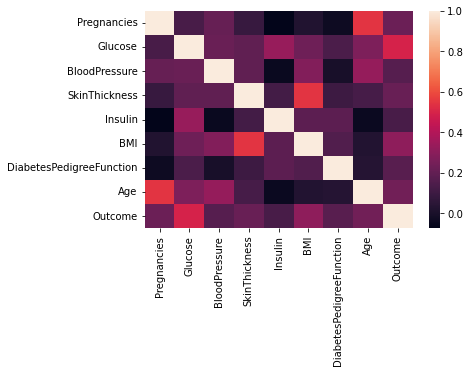

In [63]:
sns.heatmap(corr)

### Testing for multicollinearity

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# dropping rows with na
data_nona = data.dropna()

In [65]:
# ref https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/ 

# identifying independent variables
independent_variables = data_nona[['Insulin', 'BMI', 'SkinThickness', 'DiabetesPedigreeFunction',
                                  'BloodPressure', 'Age', 'Pregnancies', 'Outcome']]

# VIF df
vif_data = pd.DataFrame()
vif_data["variable"] = independent_variables.columns
  
# calculating VIF for each ind. variable
vif_data["VIF"] = [variance_inflation_factor(independent_variables.values, i)
                          for i in range(len(independent_variables.columns))]
  
vif_data

variable        VIF
0                   Insulin   1.620127
1                       BMI  35.145798
2             SkinThickness  17.368756
3  DiabetesPedigreeFunction   3.244580
4             BloodPressure  30.691221
5                       Age  13.763860
6               Pregnancies   3.356451
7                   Outcome   1.770045

In [66]:
# -> Skin Thickness, BloodPressure and BMI have high correlation, so we shouldn't test these features 
# together to avoid a model with high multicollinearity

# for my model I should use 1 of these 4 variables (the one that 
# leads to the best accuracy), but not 2, 3 or all 4 together.

# 5. T-tests

In [67]:
px.box(data, y="Insulin", color="Outcome", width=500, title='Insulin')

In [68]:
px.box(data, y='DiabetesPedigreeFunction', color='Outcome', width=500, title='Hereditary Risk')

# -> people with higher biological/hereditary risk are more likely to be 
# diabetic (makes sense), but some people without that risk factor are diabetic
# and some people with that risk don't have diabetes

# --> two-sample t-test to test if the means are significantly different or not
# (between diabetic vs non-diabetic, in regards to DPF)

In [69]:
px.box(data, y='BloodPressure', color='Outcome', width=500, title='Blood Pressure')

In [70]:
px.box(data, y='Glucose', color='Outcome', width=500, title='Glucose')

In [71]:
px.box(data, y='SkinThickness', color='Outcome', width=500, title='Skin Thickness')

In [72]:
px.box(data, y='Age', color='Outcome', width=500, title='Age')

In [73]:
px.box(data, y='Pregnancies', color='Outcome', width=500, title='Number of pregnancies')

In [74]:
px.box(data, y='BMI', color='Outcome', width=500, title='BMI')

In [75]:
# splitting the dataset between diabetic / non diabetic
diabetes = data[data['Outcome']==1]
nodiabetes = data[data['Outcome']==0]

In [76]:
# t-tests

def ttest(variable):
    print(variable + ' : ' + str(stats.ttest_ind(diabetes[variable], nodiabetes[variable])))

ttest('Age')
ttest('Pregnancies')
ttest('SkinThickness')
ttest('BMI')
ttest('Glucose')
ttest('BloodPressure')
ttest('Insulin')
ttest('DiabetesPedigreeFunction')

Age : Ttest_indResult(statistic=6.792688071649956, pvalue=2.2099754606654358e-11)
Pregnancies : Ttest_indResult(statistic=6.298430550035151, pvalue=5.065127298053476e-10)
SkinThickness : Ttest_indResult(statistic=6.089214889295934, pvalue=1.7939583262325828e-09)
BMI : Ttest_indResult(statistic=9.090064413986648, pvalue=8.336902677509037e-19)
Glucose : Ttest_indResult(statistic=15.673795182294105, pvalue=3.1287190418423694e-48)
BloodPressure : Ttest_indResult(statistic=4.65097622072597, pvalue=3.8908354906479115e-06)
Insulin : Ttest_indResult(statistic=3.64432538765356, pvalue=0.00028618646036031987)
DiabetesPedigreeFunction : Ttest_indResult(statistic=4.88582646072744, pvalue=1.254607010148809e-06)


In [77]:
# -> all p-values are significant

In [78]:
highrisk = data[data['DPF_binned']=='low (<0.30)']
lowrisk = data[data['DPF_binned']=='high (0.63-2.45)']

In [79]:
def ttest(variable):
    print(variable + ' : ' + str(stats.ttest_ind(highrisk[variable], lowrisk[variable])))

ttest('Glucose')

Glucose : Ttest_indResult(statistic=-3.1808090523496473, pvalue=0.0015604071861472257)


In [80]:
px.box(data, y='Glucose', color='DPF_binned', width=500, title='Glucose')

# better do a one-way anova though, so the 3 levels can be included in the analysis

In [81]:
px.box(data, y='BMI', color='DPF_binned', width=500, title='BMI')

In [82]:
px.box(data, y='Insulin', color='DPF_binned', width=500, title='BMI')

In [83]:
ttest('BMI') # significant: so hereditary risk & BMI are related
ttest('Pregnancies') # not significant: expected
ttest('Age') # not significant: expected
ttest('BloodPressure') # not significant: ok, interesting
ttest('Insulin') # significant

BMI : Ttest_indResult(statistic=-3.547450789591195, pvalue=0.000425841347882673)
Pregnancies : Ttest_indResult(statistic=0.624036223046878, pvalue=0.5328901171282379)
Age : Ttest_indResult(statistic=-0.9106104091493301, pvalue=0.36294210712700226)
BloodPressure : Ttest_indResult(statistic=0.03988579332860003, pvalue=0.9682001942250645)
Insulin : Ttest_indResult(statistic=-4.558180868562655, pvalue=6.503251125948279e-06)


# 6. Testing Assumptions of Normality & Equal Variance

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import pingouin as pg

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

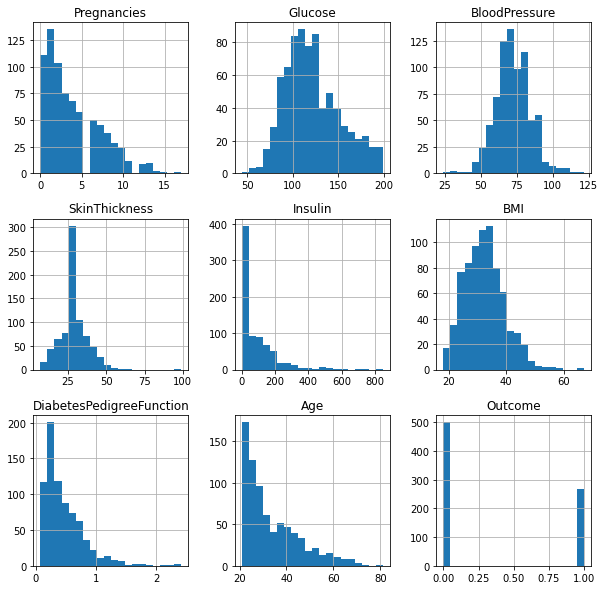

In [85]:
data.hist(bins = 20, figsize = (10,10))

In [86]:
# qqplots for those that look normal-ish

pg.qqplot(data.Glucose, dist='norm')

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

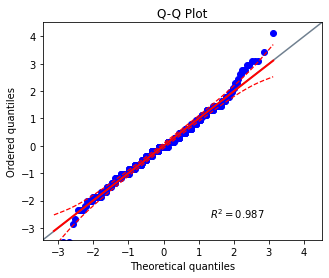

In [87]:
pg.qqplot(data.BloodPressure, dist='norm')

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

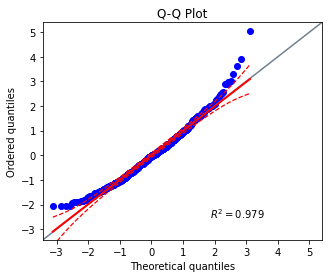

In [88]:
pg.qqplot(data.BMI, dist='norm')

In [89]:
print(pg.normality(data.Glucose))  

                W          pval  normal
Glucose  0.969622  1.524037e-11   False


In [90]:
# shapiro test 
# ref: https://towardsdatascience.com/methods-for-normality-test-with-application-in-python-bb91b49ed0f5

alpha=0.05

for i in data.columns:
    print([i])
    a,b= stats.shapiro(data[[i]])
    print("Statistics: ",a,"p-value: ",b)
    if b < alpha:
        print("The sample is not coming from a normal distribution")
    else:
        print("The sample comes from a normal distribution")

['Pregnancies']
Statistics:  0.9042782783508301 p-value:  1.6080885881590613e-21
The sample is not coming from a normal distribution
['Glucose']
Statistics:  0.9696223139762878 p-value:  1.5240374934277767e-11
The sample is not coming from a normal distribution
['BloodPressure']
Statistics:  0.9878154993057251 p-value:  5.2496684475045186e-06
The sample is not coming from a normal distribution
['SkinThickness']
Statistics:  0.9278407692909241 p-value:  9.477603848061076e-19
The sample is not coming from a normal distribution
['Insulin']
Statistics:  0.7220207452774048 p-value:  7.915248149269491e-34
The sample is not coming from a normal distribution
['BMI']
Statistics:  0.979444146156311 p-value:  6.441978950277871e-09
The sample is not coming from a normal distribution
['DiabetesPedigreeFunction']
Statistics:  0.8365186452865601 p-value:  2.477696547502535e-27
The sample is not coming from a normal distribution
['Age']
Statistics:  0.8747662305831909 p-value:  2.401946561183188e-24
T

TypeError: '<' not supported between instances of 'str' and 'float'

In [91]:
# --> all variables fail the normality test

#### CONSTANCY OF VARIANCE TESTING

In [92]:
pg.homoscedasticity(data, dv='Glucose', group='Outcome', method='levene', alpha=0.05)

W      pval  equal_var
levene  24.031647  0.000001      False

In [93]:
pg.homoscedasticity(data, dv='Glucose', group='Age_binned', method='levene', alpha=0.05)

W      pval  equal_var
levene  2.991636  0.030258      False

In [94]:
pg.homoscedasticity(data, dv='Glucose', group='Pregnancies_binned2', method='levene', alpha=0.05)

W      pval  equal_var
levene  1.712802  0.162901       True

In [95]:
pg.homoscedasticity(data, dv='Glucose', group='BloodPressure_binned', method='levene', alpha=0.05)

W      pval  equal_var
levene  1.002611  0.391026       True

In [96]:
pg.homoscedasticity(data, dv='Glucose', group='BMI_binned', method='levene', alpha=0.05)

W      pval  equal_var
levene  7.161588  0.000096      False

In [97]:
pg.homoscedasticity(data, dv='Glucose', group='SkinThickness_binned', method='levene', alpha=0.05)

W      pval  equal_var
levene  3.17385  0.042394      False

In [98]:
pg.homoscedasticity(data, dv='Glucose', group='Insulin_binned', method='levene', alpha=0.05)

W      pval  equal_var
levene  8.953401  0.000143      False

In [99]:
pg.homoscedasticity(data, dv='Glucose', group='DPF_binned', method='levene', alpha=0.05)

W      pval  equal_var
levene  3.192801  0.041604      False

# 7. One-Way ANOVAs

In [100]:
import os
import random
import patsy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLMResults
!pip install scikit_posthocs
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

In [101]:
# DPF

aov = pg.anova(data=data, dv='Glucose', between='DPF_binned', detailed=True)
print(aov)

# significant

       Source             SS   DF           MS         F     p-unc       np2
0  DPF_binned    9133.182755    2  4566.591377  4.980074  0.007098  0.012852
1      Within  701484.067245  765   916.972637       NaN       NaN       NaN


In [102]:
# post hoc test
pt = pg.pairwise_tukey(dv='Glucose',between='DPF_binned',effsize='cohen',data=data)
print(pt)

# row 1 has a significant p-value and -0.29 effect size
# --> low DPF and high DPF have significantly different Glucose means 
# higher hereditary risk factor = higher Glucose, on average

                    A                   B     mean(A)     mean(B)      diff  \
0         low (<0.30)  medium (0.31-0.62)  118.783607  120.769517 -1.985910   
1         low (<0.30)    high (0.63-2.45)  118.783607  127.402062 -8.618455   
2  medium (0.31-0.62)    high (0.63-2.45)  120.769517  127.402062 -6.632545   

         se         T   p-tukey     cohen  
0  2.532842 -0.784064  0.712949 -0.065582  
1  2.780851 -3.099215  0.005700 -0.284611  
2  2.852277 -2.325351  0.052955 -0.219029  


In [103]:
px.box(data, y="Glucose", color="DPF_binned", width=600,
      category_orders={"DPF_binned":['low (<0.30)','medium (0.31-0.62)','high (0.63-2.45)']},
      labels={'DPF_binned':'Hereditary risk'})

In [104]:
# PREGNANCIES

aov = pg.anova(data=data, dv='Glucose', between='Pregnancies_binned2', detailed=True)
print(aov)

# significant

                Source             SS   DF           MS         F     p-unc  \
0  Pregnancies_binned2   19489.985486    3  6496.661829  7.181672  0.000093   
1               Within  691127.264514  764   904.616838       NaN       NaN   

        np2  
0  0.027427  
1       NaN  


In [105]:
# post hoc test
pt = pg.pairwise_tukey(dv='Glucose',between='Pregnancies_binned2',effsize='cohen',data=data)
print(pt)

# 4+ pregnancies and 1-3 pregnancies have Glucose means that are significantly different, with an
# effect size of -0.31
# more pregnancies = higher glucose, on average
# but if that's the case, why is group "O pregnancies" and "4+" not significant?

#### maybe try with different categorization for this variable?

# -> that's what I did, so now with binned2:
# 0-1 and 7+ groups are sign. diff., with 0.37 effect size
# and 2-3 and 7+ groups also, with -0.46 effect size

     A    B     mean(A)     mean(B)       diff        se         T   p-tukey  \
0  0-1  2-3  118.800813  116.185393   2.615420  2.959632  0.883698  0.813342   
1  0-1  4-6  118.800813  123.182857  -4.382044  2.974314 -1.473296  0.454208   
2  0-1   7+  118.800813  129.994083 -11.193270  3.005007 -3.724873  0.001199   
3  2-3  4-6  116.185393  123.182857  -6.997464  3.201774 -2.185496  0.128158   
4  2-3   7+  116.185393  129.994083 -13.808690  3.230306 -4.274731  0.000127   
5  4-6   7+  123.182857  129.994083  -6.811226  3.243763 -2.099791  0.154060   

      cohen  
0  0.086958  
1 -0.145695  
2 -0.372156  
3 -0.232653  
4 -0.459114  
5 -0.226461  


In [106]:
px.box(data, y="Glucose", color="Pregnancies_binned2",
      category_orders={"Pregnancies_binned2":['0-1','2-3','4-6', '7+']},
      labels={'Pregnancies_binned2':'Number of pregnancies'}, width=600)

In [107]:
# AGE

aov = pg.anova(data=data, dv='Glucose', between='Age_binned', detailed=True)
print(aov)

# significant

       Source             SS   DF            MS          F         p-unc  \
0  Age_binned   53048.779848    3  17682.926616  20.545018  8.239434e-13   
1      Within  657568.470152  764    860.691715        NaN           NaN   

        np2  
0  0.074652  
1       NaN  


In [108]:
pt = pg.pairwise_tukey(dv='Glucose',between='Age_binned',effsize='cohen',data=data)
print(pt)

# strongest difference is between 20s and 50s, with a -0.84 effect size
# older = higher glucose, on average 

# not a very significant difference between 30s and 40s groups

     A     B     mean(A)     mean(B)       diff        se         T  \
0  20s   30s  114.631313  126.018182 -11.386869  2.718414 -4.188790   
1  20s   40s  114.631313  125.635593 -11.004280  3.076924 -3.576390   
2  20s  50s+  114.631313  139.550562 -24.919249  3.441534 -7.240738   
3  30s   40s  126.018182  125.635593   0.382589  3.536992  0.108168   
4  30s  50s+  126.018182  139.550562 -13.532380  3.858368 -3.507280   
5  40s  50s+  125.635593  139.550562 -13.914969  4.118822 -3.378386   

        p-tukey     cohen  
0  1.832957e-04 -0.388133  
1  2.093927e-03 -0.375092  
2  6.738943e-12 -0.849398  
3  9.995470e-01  0.013041  
4  2.693938e-03 -0.461265  
5  4.255493e-03 -0.474306  


In [109]:
px.box(data, y="Glucose", color="Age_binned",
      category_orders={"Age_binned":['20s','30s','40s', '50s+']},
      labels={'Age_binned':'Age'},width=600)

In [110]:
# INSULIN

aov = pg.anova(data=data, dv='Glucose', between='Insulin_binned', detailed=True)
print(aov)

# significant

           Source             SS   DF           MS         F         p-unc  \
0  Insulin_binned  118365.808781    2  59182.90439  76.44544  5.406554e-31   
1          Within  592251.441219  765    774.18489       NaN           NaN   

        np2  
0  0.166568  
1       NaN  


In [111]:
pt = pg.pairwise_tukey(dv='Glucose',between='Insulin_binned',effsize='cohen',data=data)
print(pt)

# all are significant 
# à démêler, looks tricky

        A       B     mean(A)     mean(B)       diff        se          T  \
0     <30  31-125  120.356771  105.127660  15.229111  2.476714   6.148918   
1     <30    125+  120.356771  140.056122 -19.699352  2.442546  -8.065090   
2  31-125    125+  105.127660  140.056122 -34.928463  2.840410 -12.296980   

        p-tukey     cohen  
0  3.766086e-09  0.547334  
1  0.000000e+00 -0.707994  
2  0.000000e+00 -1.255328  


In [112]:
px.box(data, y="Glucose", color="Insulin_binned",
      category_orders={"Insulin_binned":['<30','31-125','125+']},
      labels={'Insulin_binned':'Insulin'}, width=600)

In [113]:
# BMI
aov = pg.anova(data=data, dv='Glucose', between='BMI_binned', detailed=True)
print(aov)

       Source             SS   DF            MS          F         p-unc  \
0  BMI_binned   34170.778929    3  11390.259643  12.888743  3.216649e-08   
1      Within  668105.188177  756    883.737021        NaN           NaN   

        np2  
0  0.048657  
1       NaN  


In [114]:
pt = pg.pairwise_tukey(dv='Glucose',between='BMI_binned',effsize='cohen',data=data)
print(pt)

# let's ignore underweight, because n=4
# healthy & obese groups have a significantly different Glucose mean -> -0.60 effect size
# -> higher BMI = higher Glucose

             A           B     mean(A)     mean(B)       diff         se  \
0  underweight     healthy   95.250000  108.175926 -12.925926  15.136611   
1  underweight  overweight   95.250000  118.005556 -22.755556  15.028104   
2  underweight       obese   95.250000  126.132479 -30.882479  14.927243   
3      healthy  overweight  108.175926  118.005556  -9.829630   3.618342   
4      healthy       obese  108.175926  126.132479 -17.956553   3.173496   
5   overweight       obese  118.005556  126.132479  -8.126923   2.607293   

          T       p-tukey     cohen  
0 -0.853951  8.284607e-01 -0.434811  
1 -1.514200  4.294229e-01 -0.765466  
2 -2.068867  1.643050e-01 -1.038845  
3 -2.716611  3.402415e-02 -0.330655  
4 -5.658287  1.299231e-07 -0.604034  
5 -3.116996  1.021744e-02 -0.273379  


In [115]:
t=data.dropna()
px.box(t, y="Glucose", color="BMI_binned",
      category_orders={"BMI_binned":['underweight','healthy','overweight','obese']},
      labels={'BMI_binned':'BMI'}, width=600)

In [116]:
# SkinThickness
aov = pg.anova(data=data, dv='Glucose', between='SkinThickness_binned', detailed=True)
print(aov)

                 Source             SS   DF            MS          F  \
0  SkinThickness_binned   30103.410375    2  15051.705188  16.920383   
1                Within  680513.839625  765    889.560575        NaN   

          p-unc       np2  
0  6.448597e-08  0.042362  
1           NaN       NaN  


In [117]:
pt = pg.pairwise_tukey(dv='Glucose',between='SkinThickness_binned',effsize='cohen',data=data)
print(pt)
# low skin thickness and high skin thickness have a sign. diff. Glucose mean -> eff. size -0.59
# basically, skin thickness is a proxy for BMI, so I think we should disregard it

       A      B     mean(A)     mean(B)       diff        se         T  \
0    <25  26-32  112.645000  122.165789  -9.520789  2.605523 -3.654080   
1    <25    33+  112.645000  130.212766 -17.567766  3.029770 -5.798382   
2  26-32    33+  122.165789  130.212766  -8.046976  2.659446 -3.025809   

        p-tukey     cohen  
0  8.048027e-04 -0.319216  
1  2.935416e-08 -0.589018  
2  7.223238e-03 -0.269802  


In [118]:
px.box(data, y="Glucose", color="SkinThickness_binned",
      category_orders={"SkinThickness_binned":['<25','26-32','33+']},
      labels={'SkinThickness_binned':'Skin thickness'}, width=600)

In [119]:
# BloodPressure
aov = pg.anova(data=data, dv='Glucose', between='BloodPressure_binned', detailed=True)
print(aov)

                 Source             SS   DF            MS          F  \
0  BloodPressure_binned   32349.180958    3  10783.060319  12.146021   
1                Within  678268.069042  764    887.785431        NaN   

          p-unc       np2  
0  9.014268e-08  0.045523  
1           NaN       NaN  


In [120]:
pt = pg.pairwise_tukey(dv='Glucose',between='BloodPressure_binned',effsize='cohen',data=data)
print(pt)

                      A                     B     mean(A)     mean(B)  \
0             Low (<60)        Normal (60-80)  111.822581  120.442589   
1             Low (<60)  Above Normal (81-89)  111.822581  132.535433   
2             Low (<60)            High (90+)  111.822581  132.684211   
3        Normal (60-80)  Above Normal (81-89)  120.442589  132.535433   
4        Normal (60-80)            High (90+)  120.442589  132.684211   
5  Above Normal (81-89)            High (90+)  132.535433  132.684211   

        diff        se         T       p-tukey     cohen  
0  -8.620008  3.002162 -2.871267  2.180863e-02 -0.289303  
1 -20.712852  3.761648 -5.506324  2.995850e-07 -0.695162  
2 -20.861630  5.524702 -3.776064  9.847567e-04 -0.700155  
3 -12.092844  2.973861 -4.066378  3.069468e-04 -0.405858  
4 -12.241622  5.021572 -2.437807  7.098721e-02 -0.410852  
5  -0.148777  5.509375 -0.027004  9.999929e-01 -0.004993  


In [121]:
px.box(data, y="Glucose", color="BloodPressure_binned",
      category_orders={"BloodPressure_binned":['Low (<60)','Normal (60-80)','Above Normal (81-89)','High (90+)']},
      labels={'BloodPressure_binned':'Diastolic blood pressure'}, width=600)

# 8. Two-way ANOVAs

In [122]:
px.box(data, y="Glucose", color="DPF_binned", x="BMI_binned",
      category_orders={"BMI_binned":['underweight','healthy','overweight','obese'],
                      "DPF_binned":['low (<0.30)','medium (0.31-0.62)','high (0.63-2.45)']},
      labels={'DPF_binned':'Hereditary risk'})

# maybe do this one too: the interaction of hereditary risk & obesity may be interesting?

In [123]:
px.box(data, y="Glucose", color="DPF_binned", x="Pregnancies_binned2",
      category_orders={"Pregnancies_binned2":['0-1','2-3','4-6','7+'],
                      "DPF_binned":['low (<0.30)','medium (0.31-0.62)','high (0.63-2.45)']},
      labels={'DPF_binned':'Hereditary risk', 'Pregnancies_binned2':'Number of pregnancies'})
# let's try this one

In [124]:
px.box(data, y="Glucose", color="Pregnancies_binned2", x="DPF_binned",
      category_orders={"Pregnancies_binned2":['0-1','2-3','4-6','7+'],
                      "DPF_binned":['low (<0.30)','medium (0.31-0.62)','high (0.63-2.45)']},
      labels={'DPF_binned':'Hereditary risk', 'Pregnancies_binned2':'Number of pregnancies'})

In [125]:
# TWO-WAY ANOVA
# Pregnancies & DPF on Glucose

model = ols('Glucose ~ C(DPF_binned) + C(Pregnancies_binned2) + C(DPF_binned):C(Pregnancies_binned2)',
            data=data).fit()
anova_table = sm.stats.anova_lm(model, type=2)
  
print(anova_table)

# intepretation: p-values significant
# interaction effect: p-value not significant (right?)

                                         df         sum_sq      mean_sq  \
C(DPF_binned)                           2.0    9133.182755  4566.591377   
C(Pregnancies_binned2)                  3.0   19461.845624  6487.281875   
C(DPF_binned):C(Pregnancies_binned2)    6.0    6262.782145  1043.797024   
Residual                              756.0  675759.439477   893.861692   

                                             F    PR(>F)  
C(DPF_binned)                         5.108834  0.006253  
C(Pregnancies_binned2)                7.257590  0.000084  
C(DPF_binned):C(Pregnancies_binned2)  1.167739  0.321533  
Residual                                   NaN       NaN  


In [126]:
data['Pregnancies_binned2'] = data['Pregnancies_binned2'].astype(str)

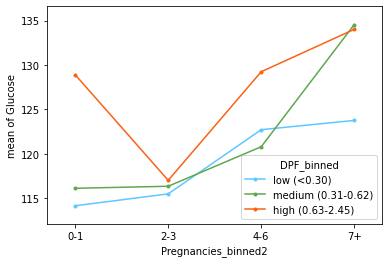

In [127]:
# INTERACTION PLOT

from statsmodels.graphics.factorplots import interaction_plot

fig = interaction_plot(data['Pregnancies_binned2'], data['DPF_binned'], data['Glucose'], 
                       colors=['#5CC8FF','#5EA650','#FC6012'])
fig.show()

In [128]:
# POSTHOC TEST DPF

res = stat()
res.tukey_hsd(df=data, res_var='Glucose', xfac_var='DPF_binned', 
              anova_model='Glucose ~ C(DPF_binned) + C(Pregnancies_binned2) + C(DPF_binned):C(Pregnancies_binned2)')
res.tukey_summary

/opt/conda/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



group1              group2      Diff     Lower      Upper  \
0    high (0.63-2.45)  medium (0.31-0.62)  6.327077 -0.336666  12.990820   
1    high (0.63-2.45)         low (<0.30)  8.172534  1.690302  14.654765   
2  medium (0.31-0.62)         low (<0.30)  1.845457 -4.054812   7.745726   

    q-value   p-value  
0  3.153405  0.066961  
1  4.187233  0.008876  
2  1.038788  0.723610

In [129]:
# POSTHOC TEST PREGNANCIES

res = stat()
res.tukey_hsd(df=data, res_var='Glucose', xfac_var='Pregnancies_binned2', 
              anova_model='Glucose ~ C(DPF_binned) + C(Pregnancies_binned2) + C(DPF_binned):C(Pregnancies_binned2)')
res.tukey_summary

/opt/conda/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



group1 group2       Diff     Lower      Upper   q-value   p-value
0    4-6    0-1   4.968474 -2.689052  12.626000  2.362662  0.340283
1    4-6     7+   6.734401 -1.591502  15.060304  2.945335  0.159804
2    4-6    2-3   7.082992 -1.134511  15.300495  3.138658  0.119078
3    0-1     7+  11.702875  3.966348  19.439402  5.508249  0.001000
4    0-1    2-3   2.114518 -5.505229   9.734265  1.010504  0.884155
5     7+    2-3  13.817393  5.526223  22.108563  6.068444  0.001000

In [130]:
# INTERACTION EFFECTS

res = stat()
res.tukey_hsd(df=data, res_var='Glucose', xfac_var=['DPF_binned', 'Pregnancies_binned2'], 
              anova_model='Glucose ~ C(DPF_binned) + C(Pregnancies_binned2) + C(DPF_binned):C(Pregnancies_binned2)')
res.tukey_summary

/opt/conda/lib/python3.8/site-packages/bioinfokit/analys.py:368: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



group1                     group2       Diff      Lower  \
0   (high (0.63-2.45), 4-6)    (high (0.63-2.45), 0-1)   1.678571 -19.597517   
1   (high (0.63-2.45), 4-6)     (high (0.63-2.45), 7+)   4.770000 -17.418206   
2   (high (0.63-2.45), 4-6)    (high (0.63-2.45), 2-3)  12.358696 -10.202840   
3   (high (0.63-2.45), 4-6)  (medium (0.31-0.62), 4-6)   8.444030 -12.617042   
4   (high (0.63-2.45), 4-6)  (medium (0.31-0.62), 0-1)  13.494444  -6.678018   
..                      ...                        ...        ...        ...   
61       (low (<0.30), 4-6)          (low (<0.30), 7+)   0.941449 -15.407932   
62       (low (<0.30), 4-6)         (low (<0.30), 2-3)   7.326667  -8.844339   
63       (low (<0.30), 0-1)          (low (<0.30), 7+)   9.609025  -6.151083   
64       (low (<0.30), 0-1)         (low (<0.30), 2-3)   1.340909 -14.234077   
65        (low (<0.30), 7+)         (low (<0.30), 2-3)   8.268116  -8.243669   

        Upper   q-value   p-value  
0   22.954660  0.365799  0.900000  
1   26.958206  0.996761  0.900000  
2   34.920231  2.539795  0.795747  
3   29.505101  1.858934  0.900000  
4   33.666907  3.101636  0.547275  
..        ...       ...       ...  
61  17.290831  0.266987  0.900000  
62  23.497673  2.100701  0.900000  
63  25.369133  2.826929  0.668763  
64  16.915895  0.399178  0.900000  
65  24.779901  2.321706  0.892196  

[66 rows x 7 columns]

In [131]:
# res.tukey_summary.to_csv('interaction_effect_summary.csv')

In [132]:
# ________________________________ testing zone ___________________________________

In [133]:
px.box(data, y="Glucose", color="Age_binned", x="BloodPressure_binned",
      category_orders={"BloodPressure_binned":['Low (<60)','Normal (60-80)','Above Normal (81-89)','High (90+)'],
                      "Age_binned":['20s','30s','40s','50s+']},
      labels={'Age_binned':'Age', 'Outcome':'Diabetes'})

In [134]:
model = ols('Glucose ~ C(Age_binned) + C(BloodPressure_binned) + C(Age_binned):C(BloodPressure_binned)',
            data=data).fit()
anova_table = sm.stats.anova_lm(model, type=2)
print(anova_table)

                                          df         sum_sq       mean_sq  \
C(Age_binned)                            3.0   53048.779848  17682.926616   
C(BloodPressure_binned)                  3.0   15774.394249   5258.131416   
C(Age_binned):C(BloodPressure_binned)    9.0    8789.879767    976.653307   
Residual                               752.0  633004.196136    841.760899   

                                               F        PR(>F)  
C(Age_binned)                          21.007066  4.464345e-13  
C(BloodPressure_binned)                 6.246585  3.431639e-04  
C(Age_binned):C(BloodPressure_binned)   1.160250  3.176738e-01  
Residual                                     NaN           NaN  


In [135]:
# ______________________________________________________________________

# 9. Regression

In [136]:
data.rcorr(stars=False, decimals=4)

# lower triangle: correlations
# upper triangle: p-values

Pregnancies Glucose BloodPressure SkinThickness  \
Pregnancies                        -  0.0004        0.0000        0.0234   
Glucose                       0.1282       -        0.0000        0.0000   
BloodPressure                 0.2086  0.2189             -        0.0000   
SkinThickness                 0.0818  0.1926        0.1919             -   
Insulin                      -0.0735  0.3317       -0.0458        0.1165   
BMI                           0.0216   0.231        0.2813        0.5432   
DiabetesPedigreeFunction     -0.0335  0.1373       -0.0024        0.1022   
Age                           0.5443  0.2669        0.3249        0.1261   
Outcome                       0.2219  0.4928        0.1657        0.2149   

                          Insulin     BMI DiabetesPedigreeFunction     Age  \
Pregnancies                0.0416  0.5508                   0.3535  0.0000   
Glucose                    0.0000  0.0000                   0.0001  0.0000   
BloodPressure              0.2052  0.0000                   0.9475  0.0000   
SkinThickness              0.0012  0.0000                   0.0046  0.0005   
Insulin                         -  0.0000                   0.0000  0.2432   
BMI                         0.185       -                   0.0000  0.4787   
DiabetesPedigreeFunction   0.1851  0.1534                        -   0.353   
Age                       -0.0422  0.0256                   0.0336       -   
Outcome                    0.1305   0.312                   0.1738  0.2384   

                         Outcome  
Pregnancies               0.0000  
Glucose                   0.0000  
BloodPressure             0.0000  
SkinThickness             0.0000  
Insulin                   0.0003  
BMI                       0.0000  
DiabetesPedigreeFunction  0.0000  
Age                       0.0000  
Outcome                        -

In [137]:
pairwise_corr = data.pairwise_corr(method='spearman', padjust='holm')
pairwise_corr[['X', 'Y', 'r', 'p-corr']].round(3)

X                         Y      r  p-corr
0                Pregnancies                   Glucose  0.129   0.005
1                Pregnancies             BloodPressure  0.190   0.000
2                Pregnancies             SkinThickness  0.091   0.112
3                Pregnancies                   Insulin -0.127   0.006
4                Pregnancies                       BMI  0.001   1.000
5                Pregnancies  DiabetesPedigreeFunction -0.043   0.925
6                Pregnancies                       Age  0.607   0.000
7                Pregnancies                   Outcome  0.199   0.000
8                    Glucose             BloodPressure  0.243   0.000
9                    Glucose             SkinThickness  0.188   0.000
10                   Glucose                   Insulin  0.207   0.000
11                   Glucose                       BMI  0.225   0.000
12                   Glucose  DiabetesPedigreeFunction  0.091   0.112
13                   Glucose                       Age  0.282   0.000
14                   Glucose                   Outcome  0.481   0.000
15             BloodPressure             SkinThickness  0.204   0.000
16             BloodPressure                   Insulin -0.086   0.138
17             BloodPressure                       BMI  0.290   0.000
18             BloodPressure  DiabetesPedigreeFunction  0.010   1.000
19             BloodPressure                       Age  0.366   0.000
20             BloodPressure                   Outcome  0.171   0.000
21             SkinThickness                   Insulin  0.083   0.145
22             SkinThickness                       BMI  0.550   0.000
23             SkinThickness  DiabetesPedigreeFunction  0.059   0.510
24             SkinThickness                       Age  0.182   0.000
25             SkinThickness                   Outcome  0.216   0.000
26                   Insulin                       BMI  0.176   0.000
27                   Insulin  DiabetesPedigreeFunction  0.221   0.000
28                   Insulin                       Age -0.114   0.017
29                   Insulin                   Outcome  0.066   0.394
30                       BMI  DiabetesPedigreeFunction  0.134   0.003
31                       BMI                       Age  0.121   0.010
32                       BMI                   Outcome  0.307   0.000
33  DiabetesPedigreeFunction                       Age  0.043   0.925
34  DiabetesPedigreeFunction                   Outcome  0.175   0.000
35                       Age                   Outcome  0.309   0.000

# Simple linear regression

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#### Simple Linear Regressions: predictor to outcome (OUTCOME = GLUCOSE)

1. DPF
2. BMI
3. SkinThickness
4. BloodPressure
5. Pregnancies
6. Age
7. Insulin
8. Outcome (diabetes)

In [139]:
### 1. DPF

px.scatter(data, x='DiabetesPedigreeFunction', y='Glucose',trendline="ols")

In [140]:
data_regression = data[['DiabetesPedigreeFunction','Glucose']]

X = data_regression.iloc[:,:-1].values
y = data_regression.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('DPF:')
print(regressor.intercept_)  # printing the intercept
print(regressor.coef_) # for every 1 DPF, glucose goes up 11

DPF:
116.46721798967958
[11.12773566]


In [141]:
# making predictions
y_pred = regressor.predict(X_test)  #use testing data

# comparing actual values of y to predictions

df = pd.DataFrame({'Actual':y_test,
                   'Predicted':y_pred
                  })
df

Actual   Predicted
0     199.0  131.979282
1     107.0  120.962823
2      76.0  120.818163
3     166.0  122.999199
4     111.0  123.811524
..      ...         ...
149   105.0  124.379038
150    85.0  119.872305
151   142.0  123.644607
152   116.0  117.657886
153   107.0  125.603089

[154 rows x 2 columns]

In [142]:
print('DPF & Glucose:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', regressor.score(X_test,y_test))

DPF & Glucose:
Mean Absolute Error: 24.430375940825176
Mean Squared Error: 937.1594188574418
Root Mean Squared Error: 30.613059612809725
R2: 0.03208777822232989


In [143]:
### 2. BMI

px.scatter(data, x='BMI', y='Glucose',trendline="ols")

In [144]:
data_regression = data[['BMI','Glucose']]

X = data_regression.iloc[:,:-1].values
y = data_regression.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('BMI:')
print(regressor.intercept_)  # printing the intercept
print(regressor.coef_)
print(regressor.score(X_test,y_test))

BMI:
86.05470721177282
[1.09120363]
0.013620613744007803


In [145]:
# making predictions
y_pred = regressor.predict(X_test)  #use testing data

# comparing actual values of y to predictions

df = pd.DataFrame({'Actual':y_test,
                   'Predicted':y_pred
                  })
df

Actual   Predicted
0     199.0  132.867343
1     107.0  122.719149
2      76.0  123.155631
3     166.0  114.207761
4     111.0  112.898317
..      ...         ...
149   105.0  122.828270
150    85.0  116.390168
151   142.0  134.067667
152   116.0  114.753363
153   107.0  119.663779

[154 rows x 2 columns]

In [146]:
print('BMI:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', regressor.score(X_test,y_test))

BMI:
Mean Absolute Error: 24.527900279133476
Mean Squared Error: 955.0398389420891
Root Mean Squared Error: 30.903718852948572
R2: 0.013620613744007803


In [147]:
### 3. SkinThickness

px.scatter(data, x='SkinThickness', y='Glucose',trendline="ols")

In [148]:
data_regression = data[['SkinThickness','Glucose']]
X = data_regression.iloc[:,:-1].values
y = data_regression.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('SKIN THICKNESS:')
print('Regressor Intercept: ', regressor.intercept_)  # printing the intercept
print('Regressor Coefficient: ', regressor.coef_)

# making predictions
y_pred = regressor.predict(X_test)  #use testing data

# comparing actual values of y to predictions

df = pd.DataFrame({'Actual':y_test,
                   'Predicted':y_pred
                  })
df

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', regressor.score(X_test,y_test))

SKIN THICKNESS:
Regressor Intercept:  104.8843051241127
Regressor Coefficient:  [0.57405031]
Mean Absolute Error: 23.717090915686835
Mean Squared Error: 902.968293564503
Root Mean Squared Error: 30.04943083594934
R2: 0.06740088224865903


In [149]:
### 4. BloodPressure

px.scatter(data, x='BloodPressure', y='Glucose',trendline="ols")

In [150]:
data_regression = data[['BloodPressure','Glucose']]
X = data_regression.iloc[:,:-1].values
y = data_regression.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('BLOOD PRESSURE:')
print('Regressor Intercept: ', regressor.intercept_)  # printing the intercept
print('Regressor Coefficient: ', regressor.coef_)

# making predictions
y_pred = regressor.predict(X_test)  #use testing data

# comparing actual values of y to predictions

df = pd.DataFrame({'Actual':y_test,
                   'Predicted':y_pred
                  })
df

BLOOD PRESSURE:
Regressor Intercept:  80.66300132301754
Regressor Coefficient:  [0.56445893]


Actual   Predicted
0     199.0  123.561880
1     107.0  122.432962
2      76.0  115.659455
3     166.0  121.304044
4     111.0  117.352832
..      ...         ...
149   105.0  125.819716
150    85.0  113.401619
151   142.0  129.206470
152   116.0  122.432962
153   107.0  121.304044

[154 rows x 2 columns]

In [151]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', regressor.score(X_test,y_test))

Mean Absolute Error: 23.89046525515935
Mean Squared Error: 930.2787277915091
Root Mean Squared Error: 30.50047094376592
R2: 0.03919425855319203


In [152]:
### 5. Pregnancies

px.scatter(data, x='Pregnancies', y='Glucose',trendline="ols")

In [153]:
data_regression = data[['Pregnancies','Glucose']]
X = data_regression.iloc[:,:-1].values
y = data_regression.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('PREGNANCIES:')
print('Regressor Intercept: ', regressor.intercept_)  # printing the intercept
print('Regressor Coefficient: ', regressor.coef_)

# making predictions
y_pred = regressor.predict(X_test)  #use testing data

# comparing actual values of y to predictions

df = pd.DataFrame({'Actual':y_test,
                   'Predicted':y_pred
                  })
df

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', regressor.score(X_test,y_test))

PREGNANCIES:
Regressor Intercept:  117.24541507472928
Regressor Coefficient:  [1.13884621]
Mean Absolute Error: 24.463975403121253
Mean Squared Error: 953.6215017935314
Root Mean Squared Error: 30.880762649156374
R2: 0.015085493499859881


In [154]:
### 6. Age

px.scatter(data, x='Age', y='Glucose',trendline="ols")

In [155]:
data_regression = data[['Age','Glucose']]
X = data_regression.iloc[:,:-1].values
y = data_regression.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('AGE:')
print('Regressor Intercept: ', regressor.intercept_)  # printing the intercept
print('Regressor Coefficient: ', regressor.coef_)

# making predictions
y_pred = regressor.predict(X_test)  #use testing data

# comparing actual values of y to predictions

df = pd.DataFrame({'Actual':y_test,
                   'Predicted':y_pred
                  })
df

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', regressor.score(X_test,y_test))

AGE:
Regressor Intercept:  97.52211003987789
Regressor Coefficient:  [0.71844788]
Mean Absolute Error: 24.018637785869792
Mean Squared Error: 937.0010277775793
Root Mean Squared Error: 30.61047251803832
R2: 0.03225136689138075


In [156]:
### 7. Insulin

px.scatter(data, x='Insulin', y='Glucose',trendline="ols")

In [157]:
data_regression = data[['Insulin','Glucose']]
X = data_regression.iloc[:,:-1].values
y = data_regression.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('INSULIN:')
print('Regressor Intercept: ', regressor.intercept_)  # printing the intercept
print('Regressor Coefficient: ', regressor.coef_)

# making predictions
y_pred = regressor.predict(X_test)  #use testing data

# comparing actual values of y to predictions

df = pd.DataFrame({'Actual':y_test,
                   'Predicted':y_pred
                  })
df

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', regressor.score(X_test,y_test))

INSULIN:
Regressor Intercept:  114.73410410627486
Regressor Coefficient:  [0.08429688]
Mean Absolute Error: 22.84495561137296
Mean Squared Error: 851.8768000883291
Root Mean Squared Error: 29.18692858264345
R2: 0.12016893853598043


In [158]:
### 8. Diabetes

data_regression = data[['Outcome','Glucose']]
X = data_regression.iloc[:,:-1].values
y = data_regression.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('DIABETES:')
print('Regressor Intercept: ', regressor.intercept_)  # printing the intercept
print('Regressor Coefficient: ', regressor.coef_)

# making predictions
y_pred = regressor.predict(X_test)  #use testing data

# comparing actual values of y to predictions

df = pd.DataFrame({'Actual':y_test,
                   'Predicted':y_pred
                  })
df

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', regressor.score(X_test,y_test))

DIABETES:
Regressor Intercept:  110.54452926208651
Regressor Coefficient:  [30.87628522]
Mean Absolute Error: 21.18551303508645
Mean Squared Error: 724.3116705802897
Root Mean Squared Error: 26.913039043933512
R2: 0.25192010641520424


### Multiple linear regression

In [159]:
data['Outcome'] = data['Outcome'].astype(str)

In [257]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'BMI_binned',
       'Pregnancies_binned2', 'Age_binned', 'Glucose_binned',
       'BloodPressure_binned', 'SkinThickness_binned', 'Insulin_binned',
       'DPF_binned'],
      dtype='object')

In [258]:
X = data[['Outcome','Insulin','Pregnancies','BloodPressure','DiabetesPedigreeFunction']] # predictors
y = data['Glucose'] # outcome

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [260]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [261]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

# If outcome is 1, +26 to Glucose
# If pregnancies +1, glucose +34

Coefficient
Outcome                     26.593331
Insulin                      0.074883
Pregnancies                  0.336589
BloodPressure                0.438510
DiabetesPedigreeFunction     0.160797

In [262]:
y_pred = regressor.predict(X_test)

In [263]:
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

Actual   Predicted
661   199.0  133.189484
122   107.0  113.384804
113    76.0  101.305499
14    166.0  145.756512
529   111.0  101.317927
..      ...         ...
476   105.0  149.472888
482    85.0  103.207044
230   142.0  138.463915
527   116.0  114.048050
380   107.0  110.890358

[154 rows x 2 columns]

In [264]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 20.08749639456982
MSE: 660.9818793374919
RMSE: 25.709567855907107


In [266]:
print(regressor.score(X_train,y_train))

# R2 = proportion of variance in the dependent variable explained by the predictors

0.3461513988666902


In [267]:
print(regressor.score(X_test,y_test))

# R-square is reasonably the same for test and train,
# which means I didn't overfit (or at least not too much)

0.3173280591211214


In [ ]:
# _____________________________

In [268]:
# making a better viz for simple regression

In [269]:
glucose_melt = pd.melt(data.reset_index(), id_vars=['Glucose'], value_vars=['Pregnancies',  
                                                                       'BloodPressure', 'SkinThickness', 
                                                                       'Insulin', 'BMI', 
                                                                       'DiabetesPedigreeFunction', 'Age', 
                                                                       'Outcome'])

glucose_melt

Glucose     variable value
0       148.0  Pregnancies     6
1        85.0  Pregnancies     1
2       183.0  Pregnancies     8
3        89.0  Pregnancies     1
4       137.0  Pregnancies     0
...       ...          ...   ...
6139    101.0      Outcome     0
6140    122.0      Outcome     0
6141    121.0      Outcome     0
6142    126.0      Outcome     1
6143     93.0      Outcome     0

[6144 rows x 3 columns]

In [270]:
import re

fig = px.scatter(glucose_melt, x="value", y="Glucose", facet_col="variable",
                facet_col_wrap=4, trendline='ols', trendline_color_override='orange')

for k in fig.layout:
    if re.search('xaxis[1-9]+', k):
        fig.layout[k].update(matches=None)

fig.show()